In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
import seaborn as sns

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torchinfo import summary
from torch.optim.lr_scheduler import StepLR, MultiStepLR, ExponentialLR
from torch.nn import MSELoss

from torch.utils.data import TensorDataset, DataLoader
from PIL import Image

import random 
import os

def seed_everything(seed = 42):
     random.seed(seed)
     os.environ['PYTHONHASHSEED'] = str(seed)
     np.random.seed(seed)     
     torch.manual_seed(seed)
     torch.cuda.manual_seed(seed)
     torch.backends.cudnn.deterministic = True

seed_everything()
None

# Data

### Parsing and overview the data

In [2]:
path = 'C:\\Main\\Code\\def\\Science\\Total_RCS'
os.chdir(path)

# Train

os.chdir(path + '\Train')
tr_files = os.listdir()
tr_files = list(filter(lambda x: x[0] in '-0123456789', tr_files))
print(tr_files)

os.chdir(path + '\Test')
tst_files = os.listdir()
tst_files = list(filter(lambda x: x[0] in '-0123456789', tst_files))
print(tst_files)

['10.txt', '15.txt', '20.txt', '25.txt', '30.txt', '32.txt', '35.txt', '40.txt', '43.txt', '45.txt', '5.txt', '50.txt', '55.txt', '60.txt', '65.txt', '70.txt', '73.txt', '75.txt']
['12.5.txt', '14.txt', '16.txt', '18.txt', '19.txt', '21.txt', '22.txt', '23.txt', '24.txt', '26.txt', '27.txt', '28.txt', '31.txt', '32.txt', '33.txt', '34.txt', '36.txt', '38.txt', '42.txt', '43.txt', '44.txt', '46.txt', '47.2.txt', '57.txt', '58.txt', '61.txt', '63.txt', '68.txt', '7.txt', '71.txt', '72.txt', '73.txt', '74.txt', '8.txt', '9.txt']


In [3]:
def checker(current, sharp_no):
    # sharp_no - 2-d list like [[0, 0, 0], 0]
    # [0, 0, 0] - counter of passed # respectevily
    # 0 - counter of current parameter iteration (C_p_1, C_p_2, ...)
    
    # 1 #
    if sum(sharp_no[0]) == 0 and current == '':
        sharp_no[1] += 1
        sharp_no[0][0] += 1
        
        return 1
    
    # 2 #
    if sum(sharp_no[0]) == 1 and current == '':
        sharp_no[0][1] += 1
        
        return 2
    
    # 3 #
    if sum(sharp_no[0]) == 2 and current == '':
        sharp_no[0][2] += 1
        
        return 3
    
    # first string
    if sum(sharp_no[0]) == 3 and current != '':
        sharp_no[0] = [0, 0, 0]
        
        return 4 # 4 - start f - RCS counting
    
    # further strings
    if current != '':
        
        return 5 # 5 - f - RCS counting

def parse_parameters(string):
    string_1 = ''.join(list(filter(lambda x: x not in '{};', string)))
    string_2 = string_1.split()[2:]
    parameters = dict()
    for el in string_2:
        el_ = el.split('=')
        parameters[el_[0]] = el_[1]
        
    return parameters

def parse_iterable(string):
    string_1 = string.split('(')[1].split(')')[0].split('=')
    iterable = dict()
    iterable[string_1[0]] = string_1[1]
    
    return iterable

def parse_fRCS(string, fRCS):
    string_1 = string.split() 
    fRCS['Frequency'].append(float(string_1[0]))
    fRCS['RCS'].append(float(string_1[1]))

def string_parser(string, fRCS, parameter_iteration):
    # file - 1-d string list ['', '234sgdfs']
    check = checker(string[0], parameter_iteration)
    if len(string) == 1 and string[0] == '': # the last string in the file (it is just a space)
        return (parameter_iteration, fRCS)
    
    if  check == 1:
        parameters = parse_parameters(string[1])
        
        return (parameter_iteration, fRCS, parameters)
    
    if check == 2:
        iterable = parse_iterable(string[1])
        
        return (parameter_iteration, iterable) 
    
    if check == 3:
        pass
    
    if check == 4 or check == 5:
        parse_fRCS(string[0], fRCS)

# for txt in file_names:

tr_df = pd.DataFrame()
tst_df = pd.DataFrame()

for site, dt_set in zip(['\Train', '\Test'], [tr_files, tst_files]):
    data = pd.DataFrame(columns = ["Frequency", "RCS"])
    os.chdir(path + site)
    for name in dt_set:
        f = open(name, 'r')
        string_file = f.read()
        f.close()
        arr_file = string_file.split('\n')
        filename = name[:name.rfind('.')]
        iterable = 0
        old_iteration = 0
        fRCS = {'Frequency': [], 'RCS':[]}
        parameter_iteration = [[0, 0, 0], -1]
        for i in range(len(arr_file)):
            string = arr_file[i].split('#')
            tup = string_parser(string, fRCS, parameter_iteration)
            if tup == None:
                continue
            if abs(tup[0][1] - old_iteration) == 1:
                old_iteration = tup[0][1]
                df_fRCS = pd.DataFrame(data = zip(*tup[1].values()), columns = tup[1].keys())
                df_fRCS[str(*iterable.keys())] = float(*iterable.values())
                df_fRCS["File_Name"] = filename
                data = pd.concat([data, df_fRCS], ignore_index=True)
                fRCS = {'Frequency': [], 'RCS':[]}
            if sum(tup[0][0]) == 2:
                iterable = tup[1]
    if site == '\Train':
        tr_df = data
    else:
        tst_df = data

In [4]:
tr_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 198000 entries, 0 to 197999
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   Frequency  198000 non-null  object 
 1   RCS        198000 non-null  object 
 2   C_p        198000 non-null  float64
 3   File_Name  198000 non-null  object 
dtypes: float64(1), object(3)
memory usage: 6.0+ MB


In [5]:
tr_df = tr_df.rename(columns = {"File_Name":"Angle"})
tr_df = tr_df.astype({'Angle':'float64', 'Frequency':'float64', 'RCS':'float64'})

tst_df = tst_df.rename(columns = {"File_Name":"Angle"})
tst_df = tst_df.astype({'Angle':'float64', 'Frequency':'float64', 'RCS':'float64'})

tr_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 198000 entries, 0 to 197999
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   Frequency  198000 non-null  float64
 1   RCS        198000 non-null  float64
 2   C_p        198000 non-null  float64
 3   Angle      198000 non-null  float64
dtypes: float64(4)
memory usage: 6.0 MB


## Check potential ranges of instability 

-------------

In [6]:
target = 'RCS'
X = ['Angle', 'Frequency','C_p']

X_train, X_test, y_train, y_test = train_test_split(tr_df[X], tr_df[target], test_size = 0.15, random_state = 42, shuffle = True)

In [7]:
scaler = StandardScaler()
X_tr_scl = scaler.fit_transform(X_train)
X_tst_scl = scaler.transform(X_test)

In [8]:
# summary(torch_model_a, input_size = (10, 200))

In [9]:
from torch.nn import MSELoss

loss_func = MSELoss()

def fit_data_torch(model, optimizer, batch_size, scheduler_1, scheduler_2, scale = False, 
                       max_epochs = 10, tol = 1e-3, silent = False, refit = False):
    def reset_weights(m):
        for layer in m.children():
            if hasattr(layer, 'reset_parameters'):
                # print(f'Reset trainable parameters of layer = {layer}')
                layer.reset_parameters()
        
    scale = scale
    model = model.to(device)
    reset_weights(model)
                        
    X_train_t = torch.FloatTensor(X_train.values).to(device) 
    y_train_t = torch.FloatTensor(y_train.to_numpy()[:, np.newaxis]).to(device)
    X_test_t = torch.FloatTensor(X_test.values).to(device)
    y_test_t = torch.FloatTensor(y_test.to_numpy()[:, np.newaxis]).to(device)
    if scale:
        X_train_t = torch.FloatTensor(X_tr_scl).to(device) 
        X_test_t = torch.FloatTensor(X_tst_scl).to(device)
        
    train_dataset = TensorDataset(X_train_t, y_train_t)
    test_dataset = TensorDataset(X_test_t, y_test_t)
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size)
    

    loaders = {'train': train_dataloader, 'test': test_dataloader}
        
    loss_storage = {"train": [], "test": []}
    accuracy_storage = {"train": [], "test": []}
    
    curr_tr, curr_tst = 0, 0
    
    start = time.time()
    for epoch in range(max_epochs):
        torch.manual_seed(42 + epoch)
        for key, dataloader in loaders.items():
            for x_batch, y_batch in dataloader:
                if key == "train":
                    model.train()
                    optimizer.zero_grad()
                    # outp = model.predict(x_batch)
                    outp = model(x_batch)
                    loss = loss_func(outp, y_batch)
                    accuracy = r2_score(y_batch.detach().cpu(), outp.detach().cpu())
                    loss.backward()
                    optimizer.step()
                else:
                    model.eval()
                    with torch.no_grad():
                        # outp = model.predict(x_batch)
                        outp = model(x_batch)
                        loss = loss_func(outp, y_batch)
                        accuracy = r2_score(y_batch.detach().cpu(), outp.detach().cpu())
                del outp, x_batch, y_batch
                torch.cuda.memory.empty_cache()
            if silent:
                loss_storage[key].append(loss.detach().cpu())
                accuracy_storage[key].append(accuracy)
            else:
                if key == "train":
                    print(f"Epoch: {epoch+1}")
                print(f"Loader: {key}. Loss: {loss} Accuracy: {accuracy}")
                loss_storage[key].append(loss.detach().cpu())
                accuracy_storage[key].append(accuracy)
                    
            ### Check convergence!        
        last_tr, last_tst = loss_storage['train'][-1], loss_storage['test'][-1]
            
        if (last_tr - curr_tr).abs() + (last_tst - curr_tst).abs() < tol:
            print('Convergence. Stop iterations.')
            break
        curr_tr, curr_tst = last_tr, last_tst
        
        scheduler_1.step()
        scheduler_2.step()
    stop = time.time()
    duration = stop - start
    
    return loss_storage, duration, accuracy_storage

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
None

In [10]:
# torch_model_1 = nn.Sequential(
#         nn.Linear(3,  120),
#         nonlin,
#         nn.Linear(120, 120),
#         nonlin,
#         nn.Linear(120, 120),
#         nonlin,
#         nn.Linear(120, 120),
#         nonlin,
#         nn.Linear(120, 1)
#     )
    
#     # nanoparticle paper
#     torch_model_2 = nn.Sequential(
#         nn.Linear(3,  300),
#         nonlin,
#         nn.Linear(300, 300),
#         nonlin,
#         nn.Linear(300, 300),
#         nonlin,
#         nn.Linear(300, 300),
#         nonlin,
#         nn.Linear(300, 1)
#  b   )

In [11]:
import pickle

def torch_models(nonlin, no):
    torch_model_1 = nn.Sequential(
      nn.Linear(3,  100),
      nonlin,
      nn.Linear(100, 1200),
      nonlin,
      nn.Linear(1200, 1000),
      nonlin,
      nn.Linear(1000, 1)
    )
    
    
    models = [torch_model_1]
        
    return models[no - 1]
#     torch_model_1 = nn.Sequential(
#         nn.Linear(3,  100),
#         nonlin,
#         nn.Linear(100, 100),
#         nonlin,
#         nn.Linear(100, 100),
#         nonlin,
#         nn.Linear(100, 1)
#     )
    
#     # nanoparticle paper
#     torch_model_2 = nn.Sequential(
#         nn.Linear(3,  300),
#         nonlin,
#         nn.Linear(300, 300),
#         nonlin,
#         nn.Linear(300, 300),
#         nonlin,
#         nn.Linear(300, 1)
#     )
    
#     # cloacking paper
#     torch_model_3 = nn.Sequential(
#         nn.Linear(3,  60),
#         nonlin,
#         nn.Linear(60,  60),
#         nonlin,
#         nn.Linear(60, 60),
#         nonlin,
#         nn.Linear(60, 60),
#         nonlin,
#         nn.Linear(60, 1)
#     )

#     # cloack + 2 layers
#     torch_model_4 = nn.Sequential(
#         nn.Linear(3,  60),
#         nonlin,
#         nn.Linear(60, 60),
#         nonlin,
#         nn.Linear(60, 60),
#         nonlin,
#         nn.Linear(60, 60),
#         nonlin,
#         nn.Linear(60, 60),
#         nonlin,
#         nn.Linear(60, 60),
#         nonlin,
#         nn.Linear(60, 1)
#     )

#     # cloack + 3 layers
#     torch_model_5 = nn.Sequential(
#         nn.Linear(3,  60),
#         nonlin,
#         nn.Linear(60, 60),
#         nonlin,
#         nn.Linear(60, 60),
#         nonlin,
#         nn.Linear(60, 60),
#         nonlin,
#         nn.Linear(60, 60),
#         nonlin,
#         nn.Linear(60, 60),
#         nonlin,
#         nn.Linear(60, 60),
#         nonlin,
        # nn.Linear(60, 1)
#     )

import time

# ----------------------------------------------------------------------------
# Beginning of training cycle
# ----------------------------------------------------------------------------

def interface(n, f, loss, dur, acc):
    print("--------------- torch_model_{}_{} ---------------".format(n, f))
    print("------------------ time: {} min ---------------".format(round(dur / 60, 2)))
    print("--------- train_loss: {} ----- test loss: {} --------".format(
        loss['train'][-1].round(), torch.round(loss['test'][-1]))
         )
    print("--------- train_acc: {} ----- test acc: {} --------".format(acc['train'][-1], acc['test'][-1]))

def cross_training(model_numbers, nonlin_list, lr, wd, ml, g, batch, epoch, model_ready, plot, step, duration_s, remove):
    # словарь для лосса и времени каждой модели: torch_model_f_n: [{train: ,test: }, time]
    keys = []
    for i in list(range(1, len(model_numbers) + 1)):
        for f in active_f_list:
            keys.append('torch_model_{}_{}'.format(i, f))

    loss_box = {}.fromkeys(keys, 0)
    # 
    
    for n_model in model_numbers:
        print('\n')
        print("=============== Model No.{} ===============".format(n_model), '\n')
        for f in range(len(nonlin_list)):
            active_f = active_f_list[f]
            ready = model_ready
            if ready:
                torch_model = torch.load('torch_model_{}_{}.pth'.format(n_model, active_f))
                print(f'...torch_model_{n_model}_{active_f}.pth loaded successfully\n')
                with open('saved_losses.pkl', 'rb') as f:
                    loss_box = pickle.load(f)
            else:
                torch_model = torch_models(nonlin_list[f], n_model)
                optimizer = torch.optim.Adam(torch_model.parameters(), lr=lr, weight_decay=wd)
                loss_test, duration_, accuracy = fit_data_torch(model = torch_model, 
                                           optimizer = optimizer, 
                                           batch_size = batch, 
                                           scale = True, 
                                           max_epochs = epoch, 
                                           tol = 1e-3, 
                                           silent = True, 
                                           scheduler_1 = ExponentialLR(optimizer, gamma = 1, last_epoch = -1, verbose = False), 
                                           scheduler_2 = MultiStepLR(optimizer, milestones = [*ml], gamma = g, verbose = False)
                                          )

                interface(n_model, active_f, loss_test, duration_, accuracy)
                loss_box['torch_model_{}_{}'.format(n_model, active_f)] = [loss_test, duration_, accuracy]
                with open('saved_losses.pkl', 'wb') as f:
                    pickle.dump(loss_box, f)
                f.close()
                torch.save(torch_model, 'torch_model_{}_{}.pth'.format(n_model, active_f))

            # ----------------------------------------------------------------------------
            # Model predictions dataframe forming
            # ----------------------------------------------------------------------------
            
            if plot:
                num_frames = int((75. - 5.)/step + 1.)
                angles = np.linspace(5, 75, num_frames)
                mask = ['Frequency', 'RCS', 'C_p', 'Angle']
                to_plot = []
                for ang in angles: #range(int(angles[0]), int(angles[-1]) + 1, 1)
                    reference = tr_df[tr_df.Angle == 60]
                    mask_1 = ['Angle', 'Frequency', 'C_p']
                    to_pred = reference[mask_1].copy()
                    to_pred.loc[to_pred.index, ['Angle']] = ang
                    to_pred_scl = scaler.transform(to_pred)
                    to_pred_t = torch.FloatTensor(to_pred_scl).to(device)
                    to_pred["RCS"] = torch_model(to_pred_t).detach().cpu()
                    to_plot.append(to_pred)

                # ----------------------------------------------------------------------------
                # Plotting every relplot, saving it and creating .gif from that
                # ----------------------------------------------------------------------------

                %matplotlib qt

                # отрисовка и сохранение relplot каждого угла
                matplotlib.use('Agg', force = True) # отрисовка inline
                for i in range(len(to_plot)):
                    plt.figure()
                    pred_data = to_plot[i][mask]
                    pred_data = pred_data.drop(columns = ['Angle'])
                    plot = sns.relplot(data=pred_data, x='Frequency', y='RCS', hue='C_p', dashes = False,
                                       kind = 'line', height = 7, aspect = 2, palette = 'bright', linewidth = 1)
                    plt.title('Angle = {}'.format(to_plot[i]['Angle'].iloc[0]))
                    plt.tight_layout()
                    sns.set_style('whitegrid')
                    newpath = f'torch_model_{n_model}_{active_f}' 
                    if not os.path.exists(newpath):
                        os.makedirs(newpath)
                    plt.savefig(f'torch_model_{n_model}_{active_f}/output_{i}.png', dpi = 'figure')
                    plt.close()

                # преобразование всех картинок в gif
                matplotlib.use('Qt5Agg', force = True) # отрисовка в отдельном графике

                # Список для хранения кадров.
                frames = []

                for frame_number in range(len(to_plot)):
                    # Открываем изображение каждого кадра.
                    frame = Image.open(f'torch_model_{n_model}_{active_f}/output_{frame_number}.png')
                    # Добавляем кадр в список с кадрами.
                    frames.append(frame)

                # Берем первый кадр и в него добавляем оставшееся кадры.
                
                frames[0].save(
                    'torch_model_{}_{}.gif'.format(n_model, active_f),
                    save_all=True,
                    append_images=frames[1:],  # Срез который игнорирует первый кадр.
                    optimize=True,
                    duration=duration_s*1000/num_frames,
                    loop=0
                )
                
                if remove:
                    # удаление картинок
                    for i in range(len(to_plot)):
                        os.remove(f"torch_model_{n_model}_{active_f}/output_{i}.png")
                    os.rmdir(f"torch_model_{n_model}_{active_f}")

            # ----------------------------------------------------------------------------
            # output: torch_model_i_f.gif and loss for that
            # ----------------------------------------------------------------------------    
            
    if ready != True:     
        with open('saved_losses.pkl', 'wb') as f:
            pickle.dump(loss_box, f)
        f.close()
    
    return loss_box

In [12]:
# nonlin_list = [nn.Tanh(), nn.GELU(), nn.ELU(), nn.Softplus()]
# active_f_list = ['Tanh', 'GELU', 'ELU', 'Softplus']
# nonlin_list = [nn.Tanh(), nn.GELU(), nn.ELU(), nn.Softplus(), nn.LeakyReLU(), nn.SELU(), nn.Softsign]
# active_f_list = ['Tanh', 'GELU', 'ELU', 'Softplus', 'LeakyReLU', 'SELU', 'Softsign']
nonlin_list = [nn.LeakyReLU()]
active_f_list = ['LeakyReLU']
# model_numbers = [1, 2, 3, 4, 5]
model_numbers = [1]
os.chdir(path + '\paper_epoch_batch_128_lr_5e-4_wd_1e-5')

loss_box = cross_training(model_numbers, nonlin_list, remove = False,
                          model_ready = True, plot = False, 
                          step = 0.5, duration_s = 7,
                          lr = 5e-4, wd = 1e-5, 
                          ml = [1], g = 1, 
                          batch = 128, epoch = 1
                         )



=============== Model No.1 =============== 

...torch_model_1_LeakyReLU.pth loaded successfully



KeyError: 'torch_model_2_LeakyReLU'

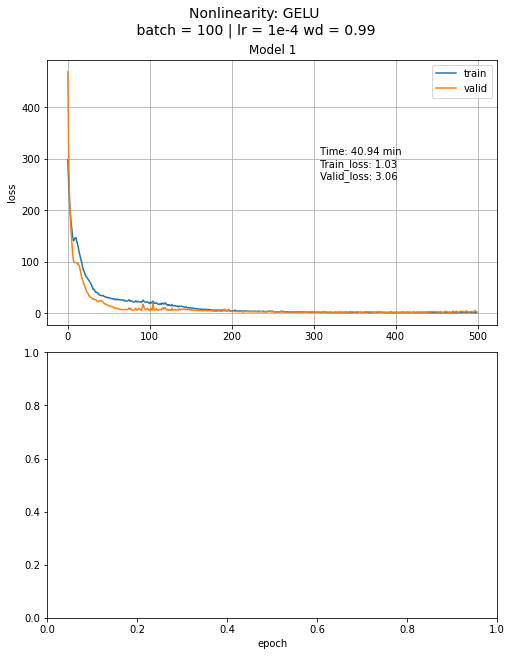

In [13]:
# loss plotting 

model_numbers = [1, 2]
fig, axs = plt.subplots(len(model_numbers), 1, sharey='row' , figsize=(7, 9), constrained_layout=True)
# fig.subplots_adjust(hspace=0.3)
fig.suptitle('Nonlinearity: GELU \n batch = 100 | lr = 1e-4 wd = 0.99 ', fontsize=14)

for n_model in model_numbers:
    for f in active_f_list:
        duration = loss_box[f'torch_model_{n_model}_{f}'][1]
        axs[n_model - 1].set_title('Model {}'.format(n_model))
        train_loss = loss_box['torch_model_{}_{}'.format(n_model, f)][0]['train']
        valid_loss = loss_box['torch_model_{}_{}'.format(n_model, f)][0]['test']
        axs[n_model - 1].grid(True)
        axs[n_model - 1].set_ylabel('loss')
        axs[n_model - 1].plot(train_loss)
        axs[n_model - 1].plot(valid_loss)
        axs[n_model - 1].legend(('train', 'valid'), loc='upper right')
        axs[n_model - 1].text(0.6, 0.55, ' Time: {} min \n Train_loss: {} \n Valid_loss: {}'.format(round(duration/60, 2), 
                                                                            round(float(train_loss[-1]), 2), 
                                                                            round(float(valid_loss[-1]), 2)), 
                              verticalalignment = 'baseline', ha = 'left', transform=axs[n_model - 1].transAxes)
        
    axs[model_numbers[-1] - 1].set_xlabel('epoch')

In [14]:
# Asessment of models

# model_numbers = [1, 2, 3, 4, 5]
# active_f_list = ['GELU']
model_numbers = [1]

scores = pd.DataFrame(index = pd.MultiIndex.from_product([[f'model_{x}' for x in model_numbers], ['min', 'mean', 'max']]), columns = [x for x in active_f_list])
tst_angles = list(set(tst_df.Angle.values))
r2_arr = []
mse_arr = []

from sklearn.metrics import mean_absolute_percentage_error

for n_model in model_numbers:
    for f in active_f_list:
        for i in tst_angles:
            # data
            check_data = tst_df[tst_df['Angle'] == i]
            X_check, y_check = check_data[['Angle', 'Frequency', 'C_p']], check_data[['RCS']]
            X_check_scl = scaler.transform(X_check)
            # model
            X = torch.FloatTensor(X_check_scl).to(device)
            model = torch.load('torch_model_{}_{}.pth'.format(n_model, f))
            pred = model(X).detach().cpu()
            r2_arr.append(r2_score(y_check.values, pred))
            mse_arr.append(mean_squared_error(pred, y_check.values))
            scores.loc[f'model_{n_model}', f].loc['max'] = max(r2_arr)
            scores.loc[f'model_{n_model}', f].loc['mean'] = sum(r2_arr)/len(r2_arr)
            scores.loc[f'model_{n_model}', f].loc['min'] = min(r2_arr)

# for i, ang in enumerate(tst_angles):
    # print(f'Angle: {ang} | R2: {r2_arr[i]} | MSE: {mse_arr[i]}\n')
scores

LeakyReLU
model_1 min   0.002042
        mean  0.315305
        max   0.742706

In [138]:
# %matplotlib qt
# def plot_trainig(train_losses, test_losses):
#     plt.figure(figsize=(10, 5))
#     plt.figtext(0.7, 0.7, ' Time: {} min \n\n Train_loss: {} \n Valid_loss: {}'.format(round(duration/60, 2), 
#                                                                             round(float(train[-1]), 2), 
#                                                                             round(float(valid[-1]), 2)), verticalalignment = 'center_baseline')
#     plt.title('Softplus_batch_1500_lr_1e-2*1e-3_100_wd_0.99')
#     plt.xlabel("epoch")
#     plt.ylabel("loss")
#     plt.plot(train_losses, label = "train_loss")
#     plt.plot(test_losses, label = "valid_loss")
#     plt.legend()
#     plt.grid(True)
#     plt.show()
    
# plot_trainig(test_, valid)

In [ ]:
import pickle

with open('saved_losses.pkl', 'rb') as f:
    loss_box = pickle.load(f)

In [15]:
# # для формирования датафрейма исходных данных

# to_plot = []
# prep_data = prep_data.sort_values(by = ['Angle'])
# for ang in range(int(angles[0]), int(angles[-1]) + 1, 5):
#     to_pred = data[data['Angle'] == ang]
#     to_plot.append(to_pred)

# # to_plot[2]

In [67]:
# fig, ax = plt.subplots(7, 2, figsize=(12, 10), constrained_layout=True)
# # ax.set_title('Train/Valid loss')
# for x, f in enumerate(active_f_list):
#     # ax.text(x, 1, f)
#     for y, model in enumerate([1, 2]):
#         loss = loss_box['torch_model_{}_{}'.format(model, f)][0]

In [82]:
def plot_trainig(train_losses, test_losses):
    plt.figure(figsize=(10, 5))
    plt.xlabel("epoch")
    plt.plot(train_losses, label = "train_loss")
    plt.plot(test_losses, label = "valid_loss")
    plt.legend()
    plt.show()
    
plot_trainig(loss_test['train'], loss_test['test'])